# Plotting animated GIFs from time series imagery

**What does this notebook do?** 

This notebook demonstrates how to import a time series of DEA cloud-free Landsat imagery from multiple sensors (i.e. Landsat 5, 7 and 8) as an xarray dataset, and then plot the data as an animated time series GIF and a transitioning/fading GIF that compares two timesteps. Animations can be produced as either GIFs or MP4s for any area in Australia using a standard datacube query.

**Required inputs**

This example uses three external functions called `load_clearlandsat`, `animated_timeseries` and `animated_fade`. These functions are available in the Scripts folder of the [dea-notebooks Github repository](https://github.com/GeoscienceAustralia/dea-notebooks/tree/master/Scripts). Note that these functions have been developed by DEA users, not the DEA development team, and so are provided without warranty. If you find an error or bug in the functions, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated function back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date:** May 2018

**Author:** Robbi Bishop-Taylor

In [5]:
# Import modules
import datacube 
import sys
import os

# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('../Scripts')
import DEADataHandling
import DEAPlotting

# Set up datacube instance
dc = datacube.Datacube(app='Time series animation')

## Set up datacube query
Define the query bounds for datacube extraction using a dict. This should include `x` and `y` limits, potentially a list of `measurements` (i.e. the bands you want to extract like 'red', 'green', 'blue'; this significantly speeds up the import) and a `time` extent. If no `time` is given, the function defaults to all timesteps available to all sensors (e.g. 1987-2018).

In [166]:
from datacube.utils import geometry
from datacube.utils.geometry import CRS

# Set up analysis data query using a buffer around a lat-long point
# lat, lon, buffer = -14.768261024, 135.367586173, 4500
# x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (361850.680639, 370200.0),
         'y': (-1574202.75509, -1568400.0),   
         'measurements': ['swir1', 'nir', 'green', 'red', 'blue'],
         'time': ('2008-01-01', '2016-12-30'),
         'crs': 'EPSG:3577'}


In [32]:
from datacube.utils import geometry
from datacube.utils.geometry import CRS

# Set up analysis data query using a buffer around a lat-long point
lat, lon, buffer = -15.052095, 129.219031, 5000
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer - 2000, x + buffer + 2000),
         'y': (y - buffer, y + buffer),    
         'measurements': ['swir1', 'nir', 'green', 'red', 'blue'],
         'time': ('1987-01-01', '2016-12-30'),
         'crs': 'EPSG:3577'}


## Extract cloud-free clear Landsat observations from all sensors
Use the `load_clearlandsat` function to load Landsat observations and PQ data for multiple sensors (i.e. ls5, ls7, ls8), and return a single xarray dataset containing only observations that contain greater than a specified proportion of clear pixels. This uses `dask` to only load in the filtered observations, and results in a visually appealing time series of observations that are not affected by cloud!

Loading ls5 PQ
    Loading 214 filtered ls5 timesteps
Loading ls7 PQ
    Loading 39 filtered ls7 timesteps
Loading ls8 PQ
    Loading 45 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
<xarray.Dataset>
Dimensions:    (time: 298, x: 561, y: 400)
Coordinates:
  * y          (y) float64 -1.596e+06 -1.596e+06 -1.596e+06 -1.596e+06 ...
  * x          (x) float64 -3.086e+05 -3.085e+05 -3.085e+05 -3.085e+05 ...
  * time       (time) datetime64[ns] 1987-09-03T00:50:08 ...
Data variables:
    swir1      (time, y, x) float64 3.049e+03 3.02e+03 2.844e+03 2.579e+03 ...
    nir        (time, y, x) float64 2.47e+03 2.428e+03 2.129e+03 2.129e+03 ...
    green      (time, y, x) float64 1.651e+03 1.538e+03 1.312e+03 1.237e+03 ...
    red        (time, y, x) float64 1.959e+03 1.959e+03 1.658e+03 1.557e+03 ...
    blue       (time, y, x) float64 1.143e+03 1.051e+03 941.0 886.0 923.0 ...
    data_perc  (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.9999 ...
Attributes:
    crs:   

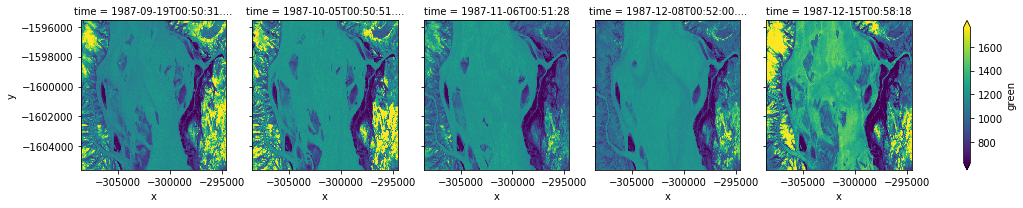

In [33]:
# Set the minimum proportion of clear pixels (pixels with no clouds or other nodata)
masked_prop=0.995

# Load in only clear Landsat observations with < 1% unclear values
# combined_ds = load_clearlandsat(dc=dc, query=query, masked_prop=masked_prop, mask_dict={'cloud_fmask': 'no_cloud', 'contiguous': True})  
combined_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, masked_prop=masked_prop)  
print(combined_ds)

# Plot first five time series images (just using the green band for simplicity):
combined_ds.green.isel(time=[1, 2, 3, 4, 5]).plot(col="time", robust=True)

## Plot entire time series as an animated GIF
The `animated_timeseries` function takes an xarray time series and exports a three band (e.g. true or false colour) GIF or MP4 animation showing changes in the landscape across time. Here, we plot the xarray as an animated GIF that includes a date annotation for each frame. We set the interval between the animation frames to 80 milliseconds, and set `reflect_stand=2500` to use a bright and vibrant colour stretch:

In [28]:
# Remove dodgy images
times_to_drop = combined_ds.nir.loc['2006-09-26':'2006-11-20'].time.values
combined_ds_subset = combined_ds.drop(times_to_drop, dim="time")
combined_ds_subset

# Select only April to November
month = combined_ds_subset['time.month']
winter = (month > 3) & (month < 12)
combined_ds_subset = combined_ds_subset.where(winter, drop=True)
combined_ds_subset 


<xarray.Dataset>
Dimensions:    (time: 119, x: 401, y: 400)
Coordinates:
  * y          (y) float64 -1.596e+06 -1.596e+06 -1.596e+06 -1.596e+06 ...
  * x          (x) float64 -3.066e+05 -3.065e+05 -3.065e+05 -3.065e+05 ...
  * time       (time) datetime64[ns] 2008-04-12T01:19:10.500000 ...
Data variables:
    swir1      (time, y, x) float64 1.666e+03 1.506e+03 1.492e+03 1.416e+03 ...
    nir        (time, y, x) float64 1.794e+03 1.595e+03 1.523e+03 1.618e+03 ...
    green      (time, y, x) float64 1.082e+03 934.0 864.0 831.0 748.0 701.0 ...
    red        (time, y, x) float64 1.264e+03 1.083e+03 997.0 1.005e+03 ...
    blue       (time, y, x) float64 739.0 570.0 536.0 520.0 459.0 396.0 ...
    data_perc  (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
Attributes:
    crs:      EPSG:3577

## Use ogr2ogr to clip mangroves database

In [29]:
for year in range(1985, 2018):
    
    # Extract extent for extraction
    left, bottom, right, top = combined_ds_subset.extent.boundingbox

    # Set up OGR2OGR parameters
    out_data = "/g/data/r78/rt1527/mangroves/raw_data/{}.shp".format(year)
    in_data = "/g/data/r78/pjb552/MangChangePVFC_V5/AustraliaMangroveChange_v5.0.sqlite"
    timestep = "Mangroves_{}".format(year)

    # Run OGR2OGR
    !ogr2ogr -f "ESRI Shapefile" $out_data $in_data $timestep -spat $left $top $right $bottom -skipfailures
    

ERROR 1: Couldn't fetch requested layer 'Mangroves_1985'!
ERROR 1: Couldn't fetch requested layer 'Mangroves_1986'!
ERROR 1: Couldn't fetch requested layer 'Mangroves_2017'!


In [31]:
# Load modules
import numpy as np
from skimage import exposure
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import calendar

import shapefile as shp


def animated_timeseries(ds, output_path, bands=['red', 'green', 'blue'], reflect_stand=5000, width_pixels=300,
                        interval=100, font_size=25):
    
    """
    Takes an xarray time series and exports a three band (e.g. true or false colour) GIF or MP4 animation showing 
    changes in the landscape across time.
    
    Last modified: May 2018
    Author: Robbi Bishop-Taylor
    
    :param ds: 
        An xarray dataset with multiple time steps (i.e. multiple observations along the `time` dimension)
        
    :param output_path: 
        A string giving the output location and filename of the resulting animation. File extensions of '.gif'
        and '.mp4' are accepted.
        
    :param bands:
        Optional list of exactly three bands to be plotted, all of which must exist in the input xarray dataset.
        Defaults to `['red', 'green', 'blue']`.
        
    :param reflect_stand:
        An integer that allows you to have greater control over the contrast stretch by manually specifying a
        reflectance standardisation value. Low values (< 5000) result in brighter images. Defaults to 5000. 
        
    :param width_pixels:
        An integer defining the output width in pixels for the resulting animation. The height of the animation is
        set automatically based on the dimensions/ratio of the input xarray dataset. Defaults to 300 pixels wide.
        
    :param interval:
        An integer defining the milliseconds between each animation frame used to control the speed of the output
        animation. Higher values result in a slower animation. Defaults to 100 milliseconds between each frame.    
    
    :param font_size:
        An integer that allows you to set the font size for the animation's date annotation. Defaults to 25.   
        
    :example:
    
    >>> # Import modules
    >>> import datacube     
    >>> 
    >>> # Set up datacube instance
    >>> dc = datacube.Datacube(app='Time series animation')
    >>> 
    >>> # Set up spatial and temporal query.
    >>> query = {'x': (-191399.7550998943, -183399.7550998943),
    >>>          'y': (-1423459.1336905062, -1415459.1336905062),
    >>>          'measurements': ['red', 'green', 'blue'],
    >>>          'time': ('2013-01-01', '2018-01-01'),
    >>>          'crs': 'EPSG:3577'}
    >>> 
    >>> # Load in only clear Landsat observations with < 1% unclear values
    >>> combined_ds = load_clearlandsat(dc=dc, query=query, masked_prop=0.99)  
    >>>
    >>> # Produce animation of red, green and blue bands
    >>> animated_timeseries(ds=combined_ds, output_path="output.mp4", 
    >>>                     interval=80, width_pixels=600, reflect_stand=3000)   
        
    """
    
    # First test if there are three bands, and that all exist in dataset:
    if (len(bands) == 3) & all([(band in ds.data_vars) for band in bands]):        

        # Get height relative to a size of 10 inches width
        width_ratio = float(ds.sizes['x']) / float(ds.sizes['y'])
        height = 10 / width_ratio

        # Iterate through each timestep and add plot to list
        ims = []
        print('Generating animation with {} frames'.format(len(ds.time)))
        for i, timestep in enumerate(ds.time):
            
            # Set up plot
            fig, ax1 = plt.subplots()
            fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
            fig.set_size_inches(10, height, forward=True)
            plt.axis('off')

            # Get human-readable date info (e.g. "16 May 1990")
            year = timestep.time.dt.year.item()
            month = calendar.month_abbr[timestep.time.dt.month.item()]
            day = timestep.time.dt.day.item()
            date_desc = '{} {} {}'.format(day, month, year)

            # Select single timestep from the data array
            ds_i = ds.isel(time = i)

            # Create new three band array
            y, x = ds_i[bands[0]].shape
            rawimg = np.zeros((y, x, 3), dtype=np.float32)

            # Add xarray bands into three dimensional numpy array
            for band, colour in enumerate(bands):

                rawimg[:, :, band] = ds_i[colour].values

            # Stretch contrast using defined reflectance standardisation; defaults to 5000
            img_toshow = (rawimg / reflect_stand).clip(0, 1)

            # Plot image for each timestep and append to list
            left, bottom, right, top = ds.extent.boundingbox
            ax1.imshow(img_toshow, animated=True, extent=[left, right, bottom, top])

            # Set up text
            ax1.annotate(date_desc, 
                             xy=(1, 1), xycoords='axes fraction', 
                             xytext=(-5, -5), textcoords='offset points', 
                             horizontalalignment='right', verticalalignment='top', 
                             fontsize=font_size, color = "white", family='monospace')        
            
            sf = shp.Reader("/g/data/r78/rt1527/mangroves/raw_data/{}.shp".format(np.max([year, 1987])))   
            for shape in sf.shapeRecords():
                
                if len(shape.shape.parts) == 1:
                    x = [i[0] for i in shape.shape.points]             
                    y = [i[1] for i in shape.shape.points]
                    ax1.plot(x, y, c="#ffff9e",  linewidth=1.3, scalex=False, scaley=False)
                    
                else:
                    for index in range(len(shape.shape.parts)):
                        try:
                            x = [i[0] for i in shape.shape.points[shape.shape.parts[index]:shape.shape.parts[index+1]]]
                            y = [i[1] for i in shape.shape.points[shape.shape.parts[index]:shape.shape.parts[index+1]]]
                        except:
                            x = [i[0] for i in shape.shape.points[shape.shape.parts[index]:]]
                            y = [i[1] for i in shape.shape.points[shape.shape.parts[index]:]]
                        ax1.plot(x, y, c="#ffff9e", linewidth=1.2, scalex=False, scaley=False)
            
#             Export and close
            file_suffix = year + (timestep.time.dt.month.item() / 12.0) + (day / 365.0)
            fig.savefig("/g/data/r78/rt1527/mangroves/out_data/{0:.4f}.jpg".format(file_suffix))
            plt.close()
#             ims.append(ax1)   
    
#         return(ims)
         
         
# Produce time series animation of red, green and blue bands
test = animated_timeseries(ds=combined_ds_subset, output_path="/home/561/rt1527/Transfer/animated_timeseries_mangrovesoverlay2.mp4", 
                    reflect_stand=5500, bands=['swir1', 'nir', 'green'], 
                    interval=50, width_pixels=600, font_size=20)   



Generating animation with 119 frames


In [9]:
# Load modules
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
import gdal
import numpy as np
import xarray as xr
import rasterio

from datacube.utils import geometry
import fiona
import shapely.geometry
from datacube.storage.storage import write_dataset_to_netcdf


def load_clearlandsat(dc, query, sensors=['ls5', 'ls7', 'ls8'], product='nbart', 
                      masked_prop=0.99, mask_dict=None, apply_mask=False):
    
    """
    Loads Landsat NBAR or NBART and PQ data for multiple sensors (i.e. ls5, ls7, ls8), and returns a single 
    xarray dataset containing only observations that contain greater than a given proportion of clear pixels.    
  
    This function was designed to extract visually appealing time series of observations that are not
    affected by cloud, for example as an input to the `animated_timeseries` function from `DEAPlotting`.
    
    The proportion of clear pixels is calculated by summing the pixels that are flagged as being problematic
    in the Landsat PQ25 layer. By default only cloudy pixels or pixels without valid data in every band 
    are included in the calculation, but this can be customised using the `mask_dict` function.
    
    Last modified: May 2018
    Author: Robbi Bishop-Taylor, Bex Dunn
    
    :param dc: 
        A specific Datacube to import from, i.e. `dc = datacube.Datacube(app='Clear Landsat')`. This allows you to 
        also use dev environments if thay have been imported into the environment.
    
    :param query: 
        A dict containing the query bounds. Can include lat/lon, time, measurements etc. If no `time`
        query is given, the function defaults to all timesteps available to all sensors (e.g. 1987-2018)

    :param sensors:
        An optional list of Landsat sensor names to load data for. Options are 'ls5', 'ls7', 'ls8', defaults to all.

    :param product:
        An optional string specifying 'nbar' or 'nbart'. Defaults to nbart unless otherwise specified. For 
        information on the difference, see the 'GettingStartedWithLandsat5-7-8' notebook on DEA Notebooks.

    :param masked_prop:
        An optional float giving the minimum percentage of clear pixels required for a Landsat observation to be 
        loaded. Defaults to 0.99 (i.e. only return observations with less than 1% of unclear pixels).
            
    :param mask_dict:
        An optional dict of arguments to the `masking.make_mask` function that can be used to identify clear 
        observations from the PQ layer using alternative masking criteria. The default value of None masks out 
        pixels flagged as cloud by either the ACCA or Fmask alogorithms, and that have values for every band 
        (equivalent to: `mask_dict={'cloud_acca': 'no_cloud', 'cloud_fmask': 'no_cloud', 'contiguous': True}`.
        See the `Landsat5-7-8-PQ` notebook on DEA Notebooks for a list of all possible options.
        
    :param apply_mask:
        An optional boolean indicating whether resulting observations should have the PQ mask applied to filter
        out any remaining unclear cells. For example, if `masked_prop=0.99`, the filtered images may still contain
        up to 1% unclear/cloudy pixels. The default of False simply returns the resulting observations without
        masking out these pixels; True removes them. 
    
    :returns:
        An xarray dataset containing only Landsat observations that contain greater than `masked_prop`
        proportion of clear pixels.  
        
    :example:
    
    >>> # Import modules
    >>> import datacube     
    >>> 
    >>> # Set up datacube instance
    >>> dc = datacube.Datacube(app='Clear Landsat')
    >>> 
    >>> # Set up spatial and temporal query.
    >>> query = {'x': (-191399.7550998943, -183399.7550998943),
    >>>          'y': (-1423459.1336905062, -1415459.1336905062),
    >>>          'measurements': ['red', 'green', 'blue'],
    >>>          'time': ('2013-01-01', '2018-01-01'),
    >>>          'crs': 'EPSG:3577'}
    >>> 
    >>> # Load in only clear Landsat observations with < 1% unclear values
    >>> combined_ds = load_clearlandsat(dc=dc, query=query, masked_prop=0.99) 
    >>> combined_ds
        
    """
    

    # List to save results from each sensor
    filtered_sensors = []

    # Iterate through all sensors, returning only observations with > mask_prop clear pixels
    for sensor in sensors:
        
        try:

            # Lazily load Landsat data using dask. 
            print('Loading {} PQ'.format(sensor))
            data = dc.load(product = '{}_{}_albers'.format(sensor, product),
                        group_by = 'solar_day', 
                        dask_chunks={'time': 1},
                        **query)

            # Remove measurements variable from query so that PQ load doesn't fail
            pq_query = query.copy()
            if 'measurements' in pq_query: del pq_query['measurements']

            # Load PQ data
            pq = dc.load(product = '{}_pq_albers'.format(sensor),
                         group_by = 'solar_day',
                         fuse_func=ga_pq_fuser,
                         **pq_query)

            # Return only Landsat observations that have matching PQ data (this may
            # need to be improved, but seems to work in most cases)
            data = data.sel(time = pq.time, method='nearest')
            
            # If a custom dict is provided for mask_dict, use these values to make mask from PQ
            if mask_dict:
                
                # Mask PQ using custom values by unpacking mask_dict **kwarg
                good_quality = masking.make_mask(pq.pixelquality, **mask_dict)
                
            else:

                # Identify pixels with no clouds in either ACCA for Fmask
                good_quality = masking.make_mask(pq.pixelquality,
                                                 cloud_acca='no_cloud',
                                                 cloud_fmask='no_cloud',
                                                 contiguous=True)

            # Compute good data for each observation as a percentage of total array pixels
            data_perc = good_quality.sum(dim=['x', 'y']) / (good_quality.shape[1] * good_quality.shape[2])
            
            # Add data_perc data to Landsat dataset as a new xarray variable
            data['data_perc'] = xr.DataArray(data_perc, [('time', data.time)])

            # Filter and finally import data using dask
            filtered = data.where(data.data_perc >= masked_prop, drop=True)
            print('    Loading {} filtered {} timesteps'.format(len(filtered.time), sensor))
            filtered = filtered.compute()
            
            # Optionally apply mask (instead of only filtering)
            if apply_mask:
                filtered = filtered.where(good_quality)
            
            # Append result to list
            filtered_sensors.append(filtered)
        
        except:
            
            # If there is no data for sensor or if another error occurs:
            print('    Skipping {}'.format(sensor))

    # Concatenate all sensors into one big xarray dataset, and then sort by time
    print('Combining and sorting ls5, ls7 and ls8 data')
    combined_ds = xr.concat(filtered_sensors, dim='time')
    combined_ds = combined_ds.sortby('time')
                                                               
    #Filter to replace no data values with nans
    combined_ds = masking.mask_invalid_data(combined_ds)

    # Return combined dataset
    return combined_ds






Loading ls5 PQ
    Skipping ls5
Loading ls7 PQ
    Loading 36 filtered ls7 timesteps
Loading ls8 PQ
    Loading 37 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
Loading ls5 PQ
    Skipping ls5
Loading ls7 PQ
    Loading 36 filtered ls7 timesteps
Loading ls8 PQ
    Loading 37 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


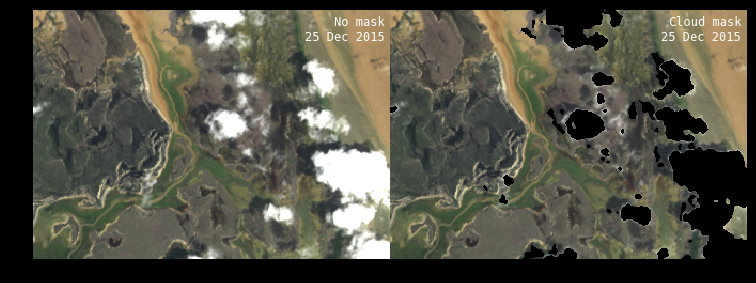

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import calendar


def animated_doubletimeseries(ds1, ds2, output_path, 
                              bands1=['red', 'green', 'blue'], bands2=['red', 'green', 'blue'], 
                              reflect_stand1=5000, reflect_stand2=5000, title1=None, title2=None,
                              width_pixels=300, interval=50, font_size=25):


    # Define function to convert xarray dataset to list of three band numpy arrays
    def _ds_to_arrraylist(ds, bands, reflect_stand=5000):   

        array_list = []
        for i, timestep in enumerate(ds.time):

                # Select single timestep from the data array
                ds_i = ds.isel(time = i)

                # Create new three band array
                y, x = ds_i[bands[0]].shape
                rawimg = np.zeros((y, x, 3), dtype=np.float32)

                # Add xarray bands into three dimensional numpy array
                for band, colour in enumerate(bands):

                    rawimg[:, :, band] = ds_i[colour].values

                # Stretch contrast using defined reflectance standardisation; defaults to 5000
                img_toshow = (rawimg / reflect_stand).clip(0, 1)
                array_list.append(img_toshow)

        return(array_list)

    # Get height relative to a size of 10 inches width
    width_ratio = float(ds1.sizes['x']) / float(ds1.sizes['y'])
    height = 10 / width_ratio

    # Set up figure
    fig, (ax1, ax2) = plt.subplots(ncols=2) # make figure
    fig.patch.set_facecolor('black')
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    fig.set_size_inches(9.9, height * 0.5, forward=True)
    ax1.axis('off')
    ax2.axis('off')

    # Import source data array
    imagelist1 = _ds_to_arrraylist(ds1, bands=bands1, reflect_stand=reflect_stand1)
    imagelist2 = _ds_to_arrraylist(ds2, bands=bands2, reflect_stand=reflect_stand2)

    # Initialise axesimage objects to be updated during animation
    im1 = ax1.imshow(imagelist1[0])
    im2 = ax2.imshow(imagelist2[0])

    # Initialise annotation objects to be updated during animation
    t1 = ax1.annotate('', xy=(1, 1), xycoords='axes fraction', 
                     xytext=(-5, -5), textcoords='offset points', 
                     horizontalalignment='right', verticalalignment='top', 
                     fontsize=font_size, color = "white", family='monospace')   
    t2 = ax2.annotate('', xy=(1, 1), xycoords='axes fraction', 
                     xytext=(-5, -5), textcoords='offset points', 
                     horizontalalignment='right', verticalalignment='top', 
                     fontsize=font_size, color = "white", family='monospace')  

    # Function to update figure
    def update_figure(frame_i):

        ###################
        # For first panel #
        ###################  

        # Get human-readable date info (e.g. "16 May 1990")
        ts = ds1.time.isel(time=frame_i).dt
        year = ts.year.item()
        month = ts.month.item()
        day = ts.day.item()
        
        # If title:
        if title1:
            date_desc1 = '{}\n{} {} {}'.format(title1, day, calendar.month_abbr[month], year)
        else:
            date_desc1 = '{} {} {}'.format(day, calendar.month_abbr[month], year)

        # Update figure for frame
        im1.set_array(imagelist1[frame_i])
        t1.set_text(date_desc1)

        ####################
        # For second panel #
        #################### 

        # Get human-readable date info (e.g. "16 May 1990")
        ts = ds2.time.isel(time=frame_i).dt
        year = ts.year.item()
        month = ts.month.item()
        day = ts.day.item()
        
        # If title:
        if title2:
            date_desc2 = '{}\n{} {} {}'.format(title2, day, calendar.month_abbr[month], year)
        else:
            date_desc2 = '{} {} {}'.format(day, calendar.month_abbr[month], year)

        # Update figure for frame
        im2.set_array(imagelist2[frame_i])
        t2.set_text(date_desc2) 

        # Return the artists set
        return [im1, im2, t1, t2]

    # Generate and run animation
    ani = animation.FuncAnimation(fig, update_figure, frames=len(ds1.time), interval=interval, blit=True)
    ani.save(output_path, dpi=width_pixels / 9.9, writer='imagemagick')


    
# Set up query 
query = {'x': (361850.680639, 370200.0),
         'y': (-1574202.75509, -1568400.0),   
         'time': ('2014-12-01', '2015-12-30'),
         'measurements': ['red', 'green', 'blue'],
         'crs': 'EPSG:3577'}

# Custom mask that includes only cloudy or cloud shadowed pixels with data for all bands
custom_mask = {'cloud_acca': 'no_cloud', 
               'cloud_fmask': 'no_cloud', 
               'cloud_shadow_acca': 'no_cloud_shadow',
               'cloud_shadow_fmask': 'no_cloud_shadow',
               'contiguous': True}

# Load in data
ds1 = load_clearlandsat(dc=dc, query=query, masked_prop=0.5, mask_dict=custom_mask, apply_mask=False)  
ds2 = load_clearlandsat(dc=dc, query=query, masked_prop=0.5, mask_dict=custom_mask, apply_mask=True) 

# Animate datasets    
animated_doubletimeseries(ds1=ds1, ds2=ds2, output_path='/home/561/rt1527/Transfer/animation_new.gif',
                          bands1=['red', 'green', 'blue'], bands2=['red', 'green', 'blue'], 
                          reflect_stand1=2500, reflect_stand2=2500, title1='No mask', title2='Cloud mask',
                          width_pixels=800, font_size=12, interval=1000)


Loading ls8_nbart_albers
Loaded ls8_nbart_albers
Generating mask ls8_pq_albers
Masked ls8_nbart_albers with ls8_pq_albers and filtered terrain
Loading ls8_nbart_albers
Loaded ls8_nbart_albers
Masked ls8_nbart_albers with ls8_pq_albers and filtered terrain


In [187]:
ds.time.isel(time=1).dt

In [117]:
print('Exporting animation to {}'.format(output_path))
input_path = '/g/data/r78/rt1527/mangroves/out_data/*.jpg'
output_path = '/home/561/rt1527/Transfer/animation.mp4'
# !ffmpeg -y -f image2 -pattern_type glob -i '/g/data/r78/rt1527/mangroves/out_data/*.jpg' /home/561/rt1527/Transfer/animation2.wmv
!ffmpeg -y -pattern_type glob -i '/g/data/r78/rt1527/mangroves/out_data/*.jpg' -qscale 3 /home/561/rt1527/Transfer/animation2.wmv
# !convert -antialias -loop 0 -delay 5 $input_path $output_path   

Exporting animation to /home/561/rt1527/Transfer/animation.mp4
ffmpeg version 3.4.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 4.8.2 (GCC) 20140120 (Red Hat 4.8.2-15)
  configuration: --prefix=/g/data/v10/public/modules/dea-env/20180405 --disable-doc --enable-shared --enable-static --extra-cflags='-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC -I/g/data/v10/public/modules/dea-env/20180405/include' --extra-cxxflags='=-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC' --extra-libs='-L/g/data/v10/public/modules/dea-env/20180405/lib -lz' --enable-pic --enable-gpl --enable-version3 --enable-hardcoded-tables --enable-avresample --enable-libfreetype --enable-gnutls --enable-libx264
  libavutil      55. 78.100 / 55. 78.100
  libavcodec     57.107.100 / 57.107.100
  libavformat    57. 83.100 / 57. 83.100
  libavdevice    57. 10.100 / 57. 10.100
  libavfilter     6.107.100 /  6.107.100
  libavresample   3.  7.  0 /  3.  7.  0
  libswscale      4.  8.100 /  4.  8.100
  libswresample   

<xarray.Dataset>
Dimensions:    (time: 4, x: 334, y: 233)
Coordinates:
  * y          (y) float64 -1.568e+06 -1.568e+06 -1.568e+06 -1.568e+06 ...
  * x          (x) float64 3.619e+05 3.619e+05 3.619e+05 3.619e+05 3.62e+05 ...
  * time       (time) datetime64[ns] 1990-11-25T00:24:23.500000 ...
Data variables:
    swir1      (time, y, x) float64 272.0 273.0 273.0 273.0 273.0 300.0 ...
    nir        (time, y, x) float64 353.0 395.0 355.0 395.0 395.0 435.0 ...
    green      (time, y, x) float64 1.043e+03 1.048e+03 1.081e+03 1.081e+03 ...
    red        (time, y, x) float64 720.0 782.0 753.0 724.0 754.0 783.0 ...
    data_perc  (time) float64 0.9979 0.9999 0.9983 1.0
Attributes:
    crs:      EPSG:3577